## column names considered for forecasting-

Order Date, Sales, Customer ID, Ship Mode, Segment, Region, Category, Sub-Category

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df = pd.read_csv("/content/final_data.csv")

In [ ]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
#df['Quarter'] = df['Order Date'].dt.quarter

In [ ]:
# One-Hot Encode Categorical Features
df_encoded = pd.get_dummies(df, columns=['Ship Mode', 'Segment', 'Region', 'Category', 'Sub-Category'], drop_first=True)

In [ ]:
# Aggregate Sales Data
monthly_features = df_encoded.groupby(['Year', 'Month']).agg({
    'Sales': 'sum',
    'Customer ID': 'nunique',  # Number of unique customers
    **{col: 'sum' for col in df_encoded.columns if col.startswith(('Ship Mode_', 'Segment_', 'Region_', 'Category_', 'Sub-Category_'))}
}).reset_index()

In [ ]:
# Generate Lag Features
monthly_features['Prev_Month_Sales'] = monthly_features['Sales'].shift(1)
monthly_features['Prev_Year_Sales'] = monthly_features['Sales'].shift(12)
monthly_features.fillna(0, inplace=True)

In [ ]:
# Train-Test Split
train = monthly_features[(monthly_features['Year'] < 2018) | ((monthly_features['Year'] == 2018) & (monthly_features['Month'] <= 11))]
test = monthly_features[(monthly_features['Year'] == 2018) & (monthly_features['Month'] == 12)]
X_train = train.drop(columns=['Sales'])
y_train = train['Sales']
X_test = test.drop(columns=['Sales'])
y_test = test['Sales']


In [ ]:
# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Initialize Models
models = {
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor()
}

In [ ]:
# Train and Evaluate Models
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape}

    print(f"Model: {name}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}%\n")

    # Select Best Model
best_model_name = min(results, key=lambda x: results[x]["MAPE"])
print(f"Best Model: {best_model_name}")
final_model = models[best_model_name]

Model: Ridge
MAE: 20785.584086396993
MSE: 432040505.81267995
RMSE: 20785.584086396993
MAPE: 25.033706738862797%

Model: Random Forest
MAE: 8712.100930000044
MSE: 75900702.61450763
RMSE: 8712.100930000044
MAPE: 10.492665438433686%

Model: XGBoost
MAE: 3735.3453750000044
MSE: 13952805.070533924
RMSE: 3735.3453750000044
MAPE: 4.498768968792866%

Best Model: XGBoost


In [ ]:
# Load Configurations
config_path = "config.yaml"
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

In [ ]:
# Train the XGBoost Model
import xgboost as xgb
model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=config['xgboost']['n_estimators'],
        learning_rate=config['xgboost']['learning_rate'],
        max_depth=config['xgboost']['max_depth'],
        subsample=config['xgboost']['subsample'],
        colsample_bytree=config['xgboost']['colsample_bytree'],
        random_state=42
    )
model.fit(X_train, y_train)

# Predictions
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(X_test)


# Calculate Errors
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print Results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 181.06
Mean Squared Error (MSE): 32781.39
Root Mean Squared Error (RMSE): 181.06
Mean Absolute Percentage Error (MAPE): 0.22%


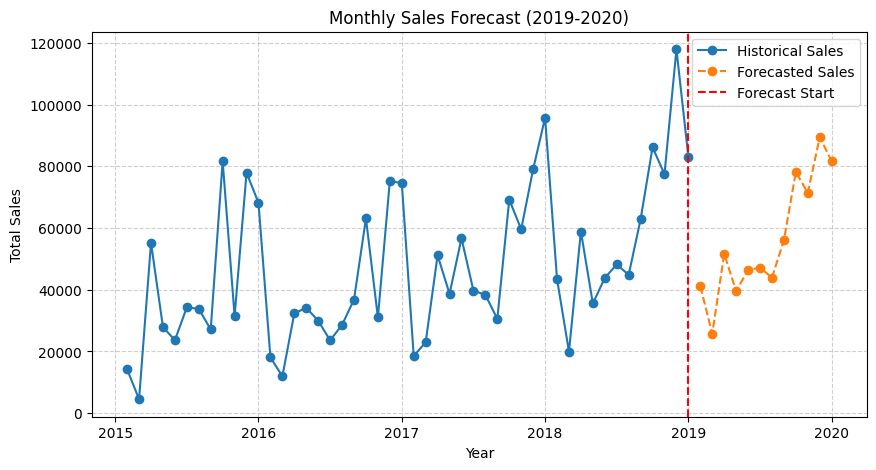

In [ ]:
# Future Predictions
future_months = pd.DataFrame({
    "Year": [2019] * 12,
    "Month": list(range(1, 13))
})
future_months['Prev_Month_Sales'] = monthly_sales['Sales'].shift(1).iloc[-12:].values
future_months['Prev_Year_Sales'] = monthly_sales['Sales'].shift(12).iloc[-12:].values
future_months.fillna(0, inplace=True)
X_future_scaled = scaler.transform(future_months)
future_sales = model.predict(X_future_scaled)

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales["Year"] + monthly_sales["Month"] / 12, monthly_sales["Sales"], marker='o', label="Historical Sales")
future_years = future_months["Year"] + future_months["Month"] / 12
plt.plot(future_years, future_sales, marker='o', linestyle='dashed', label="Forecasted Sales")
plt.axvline(x=2018 + 12/12, color='r', linestyle='dashed', label="Forecast Start")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.title("Monthly Sales Forecast (2019-2020)")
plt.show()

Sales have shown fluctuations over the years, with peaks and drops.
There is a general upward trend in sales over time.
The forecasted sales (2019-2020) follow a pattern similar to past trends, suggesting continued growth.
The prediction model captures seasonality, as seen in the repeating patterns.

In [ ]:
# Create a DataFrame to Store Forecasted Data
forecasted_data = future_months.copy()
forecasted_data["Forecasted Sales"] = future_sales

# Print the Forecasted Data Points
print("Forecasted Data Points:")
print(forecasted_data)


Forecasted Data Points:
    Year  Month  Prev_Month_Sales  Prev_Year_Sales  Forecasted Sales
0   2019      1         95739.121        18542.491      41299.917969
1   2019      2         43476.474        22978.815      26464.384766
2   2019      3         19920.997        51165.059      51998.976562
3   2019      4         58863.413        38679.767      40174.160156
4   2019      5         35541.910        56656.908      47030.582031
5   2019      6         43825.982        39724.486      47187.804688
6   2019      7         48190.728        38320.783      43944.417969
7   2019      8         44825.104        30542.200      55732.953125
8   2019      9         62837.848        69193.392      76652.960938
9   2019     10         86152.888        59583.033      70241.539062
10  2019     11         77448.131        79066.496      85604.304688
11  2019     12        117938.155        95739.121      78363.101562


In [ ]:
The forecasted data suggests seasonal trends, a Q1 slowdown, mid-year stability , and  a strong Q4 peak.

## Sales Forecasting with Facebook Prophet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

In [ ]:

# Convert Order Date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Aggregate sales data monthly
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='M')).sum().reset_index()

# Rename columns to match Prophet's requirements
monthly_sales = monthly_sales.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

# Sort data by date
monthly_sales = monthly_sales.sort_values(by='ds')

# Display sample data
print(monthly_sales.head())


          ds  Row ID                                           Order ID  \
0 2015-01-31  326299  CA-2015-103800CA-2015-112326CA-2015-112326CA-2...   
1 2015-02-28  272235  CA-2015-140795CA-2015-139857CA-2015-123400CA-2...   
2 2015-03-31  841782  CA-2015-104269US-2015-143707CA-2015-113880CA-2...   
3 2015-04-30  641208  US-2015-157021US-2015-157021CA-2015-138359CA-2...   
4 2015-05-31  601875  CA-2015-115056CA-2015-124618CA-2015-130274CA-2...   

                                           Ship Date  \
0  2015-01-072015-01-082015-01-082015-01-082015-0...   
1  2015-02-032015-02-062015-02-092015-02-092015-0...   
2  2015-03-062015-03-052015-03-052015-03-052015-0...   
3  2015-04-062015-04-062015-04-062015-04-062015-0...   
4  2015-05-022015-05-042015-05-052015-05-102015-0...   

                                           Ship Mode  \
0  Standard ClassStandard ClassStandard ClassStan...   
1  First ClassStandard ClassStandard ClassStandar...   
2  Second ClassStandard ClassStandard ClassS

In [ ]:
# Initialize Prophet model
model = Prophet()

# Fit model with historical sales data
model.fit(monthly_sales)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc3gb1_ho/9ysw3ms_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc3gb1_ho/q5nif6ro.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91369', 'data', 'file=/tmp/tmpc3gb1_ho/9ysw3ms_.json', 'init=/tmp/tmpc3gb1_ho/q5nif6ro.json', 'output', 'file=/tmp/tmpc3gb1_ho/prophet_modelwgm_q2dn/prophet_model-20250318044521.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:45:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:45:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Create a future dataframe for next 12 months
future = model.make_future_dataframe(periods=12, freq='M')

# Make Predictions
forecast = model.predict(future)

# Show forecasted values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds,yhat,yhat_lower,yhat_upper
48,2019-01-31,42990.573365,34059.216249,52238.599438
49,2019-02-28,31248.284358,22848.467233,40844.920240
50,2019-03-31,81267.007058,71210.547946,91055.631187
51,2019-04-30,50658.473843,41105.753315,60322.278817
52,2019-05-31,52556.020248,43375.615995,62406.825649
53,2019-06-30,60032.006973,49720.699714,69041.581521
54,2019-07-31,56249.853541,47001.436132,65121.727233
55,2019-08-31,55607.501900,46521.672188,64959.665863
56,2019-09-30,101737.534976,91660.475604,111158.461380
57,2019-10-31,69352.281837,59551.863832,77730.889538


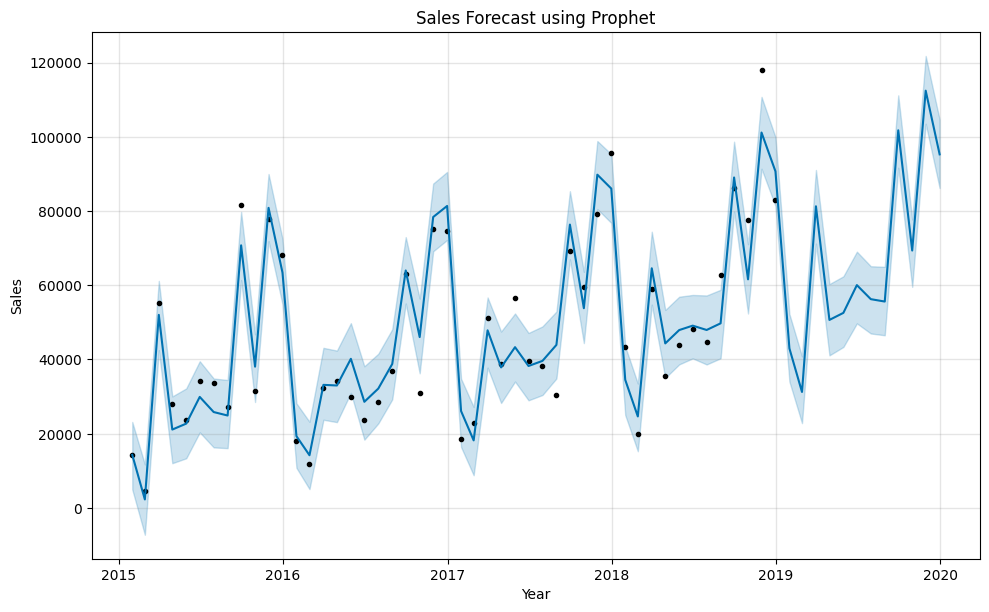

In [ ]:
# Plot forecast
model.plot(forecast)
plt.title("Sales Forecast using Prophet")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.show()


Some outliers (black dots) deviate from the forecast, suggesting unexpected spikes or drops.
The model effectively captures seasonality, but further refinements—such as incorporating external factors—could improve accuracy.